In [1]:
import os
import torch
import pandas as pd
import numpy as np
import time
from collections import Counter

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import pytorch_lightning as pl

In [2]:
data = pd.read_csv("data/generated_data.csv", index_col=0)
data.head()

,query,time
0,imageflow_tool v1/querystring --in in/37.webp ...,0.062320
1,imageflow_tool v1/querystring --in in/17.jpeg ...,0.044926
2,imageflow_tool v1/querystring --in in/8.jpeg -...,0.023656
3,imageflow_tool v1/querystring --in in/waterhou...,0.118022
4,imageflow_tool v1/querystring --in in/7.webp -...,0.040955


In [3]:
queries = data["query"].tolist()
queries = list(map(lambda s: s[38:].split(" "), queries))
queries = list(map(lambda l: (l[0] + "&" + l[4][1:-1]).split("&"), queries))
all_tokens = [token for query in queries for token in query]
counts = Counter(all_tokens)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {token: ii for ii, token in enumerate(vocab, 1)}

In [4]:
query_ints = [] 
for query in queries:     
    query_ints.append([vocab_to_int[token] for token in query])

In [5]:
runtimes = data["time"].tolist()
labels = np.array([1 if runtime > 1 else 0 for runtime in runtimes])

In [6]:
seq_len = max([len(x) for x in query_ints])

In [7]:
def pad_queries(encoded_seq, seq_length):
    padded = np.zeros((len(encoded_seq), seq_length), dtype=int)
    for i, row in enumerate(encoded_seq):
        padded[i, -len(row):] = np.array(row)[:seq_length]
    return padded

features = pad_queries(query_ints, seq_len)

In [8]:
split_frac = 0.8

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

In [9]:
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

batch_size = 50

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [10]:
my_acc = []
val_acc = []
class Classifier(pl.LightningModule):

    def __init__(self):
        super().__init__()
        embedding_dim = 16
        self.embed = nn.Embedding(len(vocab)+1, embedding_dim)
        self.net = nn.Sequential(
            nn.Linear(seq_len * embedding_dim, 32), 
            nn.ReLU(),
            nn.Linear(32, 1), 
            nn.Sigmoid())
    
    def forward(self, x):
        em = self.embed(x)
        output = self.net(em.view(50,-1)).squeeze()
        pred = torch.round(output.squeeze())
        return pred

    def training_step(self, batch, batch_idx):
        x, y = batch
        em = self.embed(x)
        output = self.net(em.view(50,-1)).squeeze()
        criterion = nn.BCELoss()
        loss = criterion(output, y.float())
        self.log('train_loss', loss)
        
        pred = torch.round(output)
        correct = pred.eq(y.float())
        acc = np.sum(correct.numpy())/len(pred)
        self.log('train_accuracy', acc)
        my_acc.append(acc)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        em = self.embed(x)
        output = self.net(em.view(50,-1)).squeeze()
        criterion = nn.BCELoss()
        loss = criterion(output, y.float())
        
        pred = torch.round(output)
        correct = pred.eq(y.float())
        acc = np.sum(correct.numpy())/len(pred)
        val_acc.append(acc)
        
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer

In [11]:
my_model = Classifier()
trainer = pl.Trainer(max_epochs=25)
trainer.fit(my_model, train_loader, valid_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/isaacw/Documents/6828_final/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | embed | Embedding  | 3.2 K 
1 | net   | Sequential | 6.2 K 
/home/isaacw/Documents/6828_final/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/isaacw/Documents/6828_final/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 

/home/isaacw/Documents/6828_final/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


1

<AxesSubplot:>

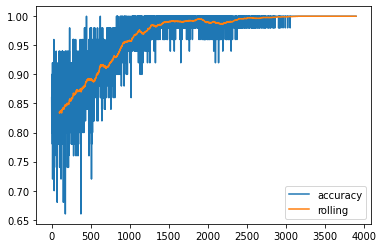

In [171]:
df = pd.DataFrame(my_acc[100:], columns=["accuracy"])
df["rolling"] = df["accuracy"].rolling(window=100).mean()
df.plot()

0.9451999999999992


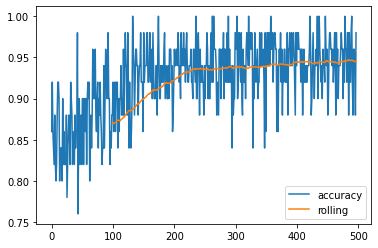

In [172]:
df = pd.DataFrame(val_acc[5:], columns=["accuracy"])
df["rolling"] = df["accuracy"].rolling(window=100).mean()
df.plot()
print(df["rolling"].tolist()[-1])

In [217]:
runtimes = []
for x, y in train_loader:
    start = time.time_ns()
    out = my_model(x)
    end = time.time_ns()
    runtimes.append((end-start)/1e3)
times = pd.DataFrame(runtimes, columns=["model runtime (microseconds)"])

In [218]:
times.describe()

,model runtime (microseconds)
count,160.000000
mean,190.344825
std,52.601335
min,165.630000
25%,178.120250
50%,181.050500
75%,185.096000
max,672.033000
